<a href="https://colab.research.google.com/github/alexmartin299/GAN-PhaseRetrieval/blob/main/GANRetrieval.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

2.3.0
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


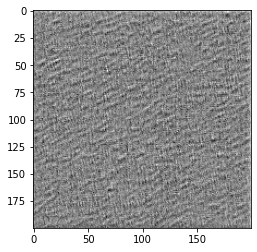

In [11]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt
print(tf.__version__)
print(tf.config.list_physical_devices('GPU'))


def make_generator_model():
    z = 10  # mm, Distància entre imatges
    f = 200  # mm, Focal
    p = 3.75e-3  # mm, mida pixel
    lamb = 520e-6  # mm, longitud d'ona

    umax = 1 / 2 / p
    u = np.linspace(-umax, umax, 200)
    v = np.linspace(-umax, umax, 200)
    v, u = np.meshgrid(u, v)

    H = np.exp(-1j * np.pi * lamb * z * (u * u + v * v))
    H = np.reshape(H,(1,200,200,1))
    img_inputs = keras.Input(shape=(200,200,1))
    #encoder
    x = layers.Conv2D(8, 3, activation="relu",padding='same')(img_inputs)
    x = layers.LeakyReLU(alpha=0.3)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(8, 3,padding='same')(x)
    x = layers.LeakyReLU(alpha=0.3)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(8, 3,padding='same')(x)
    x = layers.LeakyReLU(alpha=0.3)(x)
    block_1_output = layers.BatchNormalization()(x)

    x = layers.MaxPooling2D((2,2))(block_1_output)

    x = layers.Conv2D(16, 3, padding="same")(x)
    x = layers.LeakyReLU(alpha=0.3)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(16, 3, padding="same")(x)
    x = layers.LeakyReLU(alpha=0.3)(x)
    block_2_output = layers.BatchNormalization()(x)

    x = layers.MaxPooling2D((2,2))(block_2_output)


    #latent space
    x = layers.Conv2D(32, 3, padding="same")(x)
    x = layers.LeakyReLU(alpha=0.3)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(32, 3, padding="same")(x)
    x = layers.LeakyReLU(alpha=0.3)(x)
    x = layers.BatchNormalization()(x)

    #decoder
    x = layers.UpSampling2D((2,2))(x)

    x= layers.concatenate([x, block_2_output])
    x = layers.Conv2D(16, 3, padding="same")(x)
    x = layers.LeakyReLU(alpha=0.3)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(16, 3, padding="same")(x)
    x = layers.LeakyReLU(alpha=0.3)(x)
    x = layers.BatchNormalization()(x)

    x = layers.UpSampling2D((2,2))(x)

    x = layers.concatenate([x, block_1_output])
    x = layers.Conv2D(8, 3, padding="same")(x)
    x = layers.LeakyReLU(alpha=0.3)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(8, 3, padding="same")(x)
    x = layers.LeakyReLU(alpha=0.3)(x)
    x = layers.BatchNormalization()(x)
    output = layers.Conv2D(1, kernel_size=(3,3), padding='same')(x)
    "codigo modelo hibrido no importante"
    """phi = layers.LeakyReLU(alpha=0.3)(x)
    phi = tf.cast(phi,'complex64')
    real = tf.constant(0,dtype='float32')
    imag = tf.constant(1,dtype='float32')
    complex_j = tf.complex(real,imag)
    
    Ui = train_image*tf.math.exp(tf.math.multiply(complex_j,phi))
    Uii = tf.signal.ifft2d(tf.signal.fft2d(Ui)*H)
    output = abs(Uii)**2"""

    model = keras.Model(img_inputs, output, name="hybrid_model")

    return model

generator = make_generator_model()

noise = tf.random.normal([1,200,200,1])
generated_image = generator(noise, training=False)

plt.imshow(generated_image[0, :, :, 0], cmap='gray')
